## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


Ответ: 1. Рекомендации User-User - рекомендация товаров по принципу "похожести" пользователей, т.е. мы ищем похожих пользователей и рекомендуем им одни и те же товары. 2. Рекомендация Item-Item означает, что если пользователь купил этот товар, то и купит другой, максимально близкий (например, если пользователь купил масло, то скорее всего купит хлеб). 3. Считаю что да, можно использовать функцию для user_user_rec. 4. Я увидел отличия в том, что в ALS есть регуляризация.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


Ответ: 1. Просмотр товара; 2. Добавление в корзину; 3. Частота покупок.

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


Ответ: линейность.

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

Ответ: Bm25 —  алгоритм ранжирования страниц документов по поисковому запросу. Он определяет релевантность страниц в зависимости от количества и расположения слов (во всех блоках текста, исключая ссылки) относительно других документов. Функция называется BM25, часто ее называют также Okapi BM25, по названию поисковой системы Okapi, где она была использована впервые.
В SEO Okapi BM25 — одна из функций ранжирования, используемая поисковиками для определения соответствия страницы заданному ключевому слову. Т.е. если на странице нет фразы, соответствующей поисковому запросу, то не удастся попасть в ТОП в сравнении с конкурентами, которые ее используют.
Пример.
Есть несколько запросов состоящих из нескольких слов:
    •     купить смартфон Samsung 
    •     купить смартфон Samsung Galaxy 
Пусть сравниваются два документы и первый документ не содержит слова Galaxy.
Согласно расчетов, оценка релевантности это сумма релевантностей каждого из слов.
Релевантность каждого из слова равна его IDF * на второй множитель.
Релевантность всего поискового запроса равна сумме релевантностей всех слов.
Таким образом, отсутствие слова или другими словами его частота, равная 0, дает релевантность 0.
Поэтому если по двум первым словам score будет одинаково то более релевантным будет тот документ, который содержит слово Galaxy.
Ссылка https://ru.megaindex.com/support/faq/bm25
Способов перевзвешивания не знаю, если вы дадите литературу, то будет супер! Спасибо

## Практическая часть


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [3]:
data = pd.read_csv('/home/vyacheslav/Data Scientist/IV ЧЕТВЕРТЬ/II. Рекомендательные системы/2 lesson/data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features = pd.read_csv('/home/vyacheslav/Data Scientist/IV ЧЕТВЕРТЬ/II. Рекомендательные системы/2 lesson/data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

Количество покупок

In [8]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/home/vyacheslav/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [10]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 28.9 s, sys: 13.6 s, total: 42.5 s
Wall time: 11.8 s


In [11]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [12]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [14]:
res = []

In [17]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 1min 49s, sys: 1min 9s, total: 2min 59s
Wall time: 47.7 s


0.1614103819784525

Сумма покупок

In [25]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/home/vyacheslav/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [27]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 31.4 s, sys: 15.4 s, total: 46.9 s
Wall time: 15.1 s


In [28]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 2min 1s, sys: 1min 12s, total: 3min 14s
Wall time: 58.5 s


0.16101860920666014

покупки от недели

In [34]:
data_train['week_no_log'] = data_train['week_no'].apply(lambda x: np.log(1+x))

<ipython-input-34-110b5a532f8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['week_no_log'] = data_train['week_no'].apply(lambda x: np.log(1+x))


In [35]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='week_no_log', # Можно пробовать другие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.418841,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [36]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [37]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 29.1 s, sys: 13.1 s, total: 42.1 s
Wall time: 11.6 s


In [38]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 1min 53s, sys: 1min 10s, total: 3min 4s
Wall time: 51.7 s


0.08442703232125368

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


Ответ: сделал только на train ((( Кол-во покупок 0.1614103819784525, сумма покупок 0.16101860920666014 и покупки от недели 0.08442703232125368. Таким образом лучший вес у количества покупок.

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [39]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/home/vyacheslav/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
def ALS(user_item_matrix, factors=100, regularization=0.001, show_progress=False):

    model = AlternatingLeastSquares(factors=factors, #k
                                    regularization=regularization,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4, 
                                    random_state=123)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=show_progress)
    
    return model


def eval_precision_at_k(model, result, k=5):
    result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    res = result.apply(lambda row: precision_at_k(row['als'], row['actual'], k=k), axis=1).mean()
    return res

In [53]:
factors = [50, 100, 200, 300, 400]
lambdas = [0.01, 0.02, 0.05, 0.1, 0.5]
pr_train = []
learn_durations = []

In [54]:
import time

In [55]:
%%time

for factor in factors:
    
    start_time = time.time()
    model = ALS(user_item_matrix, factors=factor, show_progress=True)
    learn_durations.append(time.time() - start_time)
    
    pr_train.append(eval_precision_at_k(model, result))
    
pr_train, learn_durations

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 25min 51s, sys: 14min 12s, total: 40min 3s
Wall time: 11min 47s


([0.16689520078354553,
  0.15798237022526934,
  0.13310479921645446,
  0.11674828599412342,
  0.1059745347698335],
 [11.562092781066895,
  11.124110460281372,
  14.269396781921387,
  18.855881214141846,
  22.82115125656128])

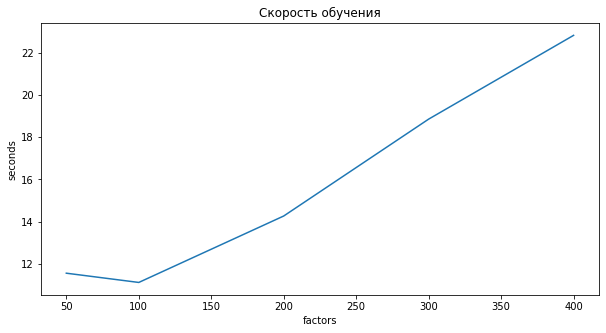

In [56]:
fig, ax = plt.subplots(figsize=(10, 5), )
ax.plot(factors, learn_durations)

plt.xlabel('factors')
plt.ylabel('seconds')
plt.title('Скорость обучения')
plt.show()

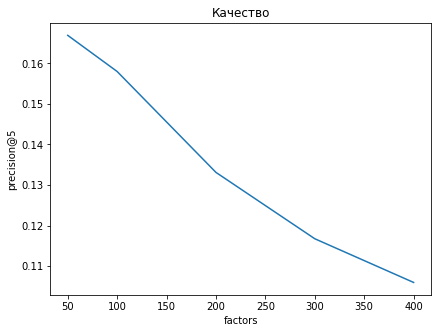

In [61]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)

ax1.plot(factors, pr_train)
ax1.set_title('Качество')
ax1.set_xlabel("factors")
ax1.set_ylabel("precision@5")
       
plt.show()

In [58]:
%%time

pr_train2 = []
learn_durations2 = []

for lambda_ in lambdas:
    
    start_time = time.time()
    model = ALS(user_item_matrix, regularization=lambda_, show_progress=True)
    learn_durations2.append(time.time() - start_time)
    
    pr_train2.append(eval_precision_at_k(model, result))
    
pr_train2, learn_durations2

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 11min 14s, sys: 6min 49s, total: 18min 4s
Wall time: 4min 41s


([0.16131243878550441,
  0.16238981390793342,
  0.1633692458374143,
  0.1636630754162586,
  0.16327130264446624],
 [10.76527738571167,
  10.358520030975342,
  10.547071933746338,
  10.627215147018433,
  10.991558313369751])

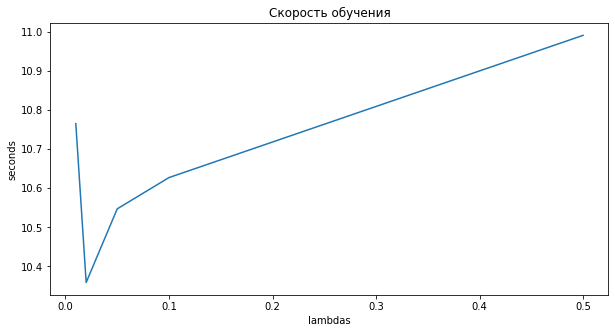

In [59]:
fig, ax = plt.subplots(figsize=(10, 5), )
ax.plot(lambdas, learn_durations2)

plt.xlabel('lambdas')
plt.ylabel('seconds')
plt.title('Скорость обучения')
plt.show()

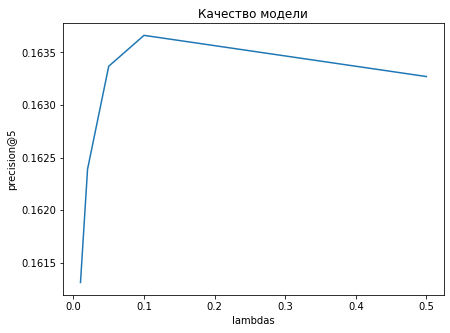

In [60]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)

ax1.plot(lambdas, pr_train2, label='precision@5 on train')
ax1.set_title('Качество модели')
ax1.set_xlabel("lambdas")
ax1.set_ylabel("precision@5")         

plt.show()

Скорость обучения при возрастании количества факторов увеличивается, что собственно, логично.
Странно, но качество с ростом факторов падает.
Скорость обучения при увеличении лямбда растет.
Качество модели с ростом лямбда сначала резко растет, затем падает — переобучение.

Написаны не отписки, на самом деле для меня нелегко, т.к. программа построена неправильно: было введение в Python, затем перерыв полгода и тебя бросают в море. Поймите правильно, но это так) поэтому делаю как могу. Спасибо

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!